# Modeling

### Imports

In [77]:
import pandas as pd
import re
from io import StringIO
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


### Loading Data

In [19]:
# Load menu food CSV file
menu_recs_samp = pd.read_csv('./preprocessed_data/menu_recs_samp.csv')
menu_recs_samp.head()

,Patient_ID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,...,Sugars,Fats,Saturated_Fats,Cholesterol,Sodium,Fiber,Potassium,Proteins,General_Score,Patient_Score
0,2290,1,0.0,1,36.0,1.0,0.0,0.0,1,4.0,...,1.45,28.07,12.26,230.14,1522.31,2.68,835.55,28.72,0.690,0.180
1,3561,1,1.0,0,27.0,1.0,1.0,1.0,1,4.0,...,0.09,11.76,2.70,46.75,78.97,0.10,364.69,20.63,0.600,0.485
2,15407,1,1.0,1,25.0,0.0,0.0,1.0,1,2.0,...,47.88,40.80,8.60,0.00,915.46,4.91,340.34,11.07,0.121,0.147
3,9295,0,1.0,0,35.0,1.0,1.0,1.0,1,5.0,...,4.60,4.05,2.22,6.36,8.16,0.30,35.64,0.75,0.175,0.000
4,13120,0,0.0,0,32.0,1.0,0.0,0.0,1,3.0,...,1.90,10.34,2.83,7.34,626.54,10.89,628.21,10.82,0.682,0.389


In [20]:
# Load individual food CSV file
individual_foods_samp = pd.read_csv('./preprocessed_data/individual_foods_samp.csv')
individual_foods_samp.head()

,Patient_ID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,...,Cluster,Food_Name,Calories,Carbohydrates,Sugars,Fats,Fiber,Proteins,General_Score,Patient_Score
0,21714,0,0.0,0,32.0,1.0,0.0,0.0,1,3.0,...,0,Wild Rice,318.80,67.380,1.0020,1.012,5.380,12.3600,0.66880,0.539
1,5788,1,1.0,1,32.0,1.0,0.0,1.0,1,4.0,...,2,Pumpkin seeds,591.75,12.475,0.8325,49.175,5.825,29.9750,0.55475,0.368
2,4269,0,0.0,1,34.0,0.0,0.0,1.0,1,4.0,...,1,White Rice,351.80,80.240,0.0000,0.000,0.780,7.0980,0.58160,0.346
3,10665,1,1.0,0,36.0,0.0,1.0,1.0,0,4.0,...,3,Wheat Bread,262.80,50.200,5.0780,3.216,3.520,10.1660,0.67120,0.312
4,22182,1,1.0,0,26.0,1.0,1.0,1.0,0,5.0,...,2,Eggplant,38.40,7.584,3.3280,0.292,2.590,0.8784,0.27820,0.247


### Recommendations Column

In [21]:
# Calculate medians for classification
median_score_menu = menu_recs_samp['Patient_Score'].median()
median_score_food = individual_foods_samp['Patient_Score'].median()

# Add recommendation labels based on medians
menu_recs_samp['Recommendation'] = menu_recs_samp['Patient_Score'].apply(
    lambda x: 'Recommended' if x >= median_score_menu else 'Not Recommended'
)
individual_foods_samp['Recommendation'] = individual_foods_samp['Patient_Score'].apply(
    lambda x: 'Recommended' if x >= median_score_food else 'Not Recommended'
)

Check the updated dataset

In [22]:
menu_recs_samp.head()

,Patient_ID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,...,Fats,Saturated_Fats,Cholesterol,Sodium,Fiber,Potassium,Proteins,General_Score,Patient_Score,Recommendation
0,2290,1,0.0,1,36.0,1.0,0.0,0.0,1,4.0,...,28.07,12.26,230.14,1522.31,2.68,835.55,28.72,0.690,0.180,Not Recommended
1,3561,1,1.0,0,27.0,1.0,1.0,1.0,1,4.0,...,11.76,2.70,46.75,78.97,0.10,364.69,20.63,0.600,0.485,Recommended
2,15407,1,1.0,1,25.0,0.0,0.0,1.0,1,2.0,...,40.80,8.60,0.00,915.46,4.91,340.34,11.07,0.121,0.147,Not Recommended
3,9295,0,1.0,0,35.0,1.0,1.0,1.0,1,5.0,...,4.05,2.22,6.36,8.16,0.30,35.64,0.75,0.175,0.000,Not Recommended
4,13120,0,0.0,0,32.0,1.0,0.0,0.0,1,3.0,...,10.34,2.83,7.34,626.54,10.89,628.21,10.82,0.682,0.389,Recommended


In [23]:
individual_foods_samp.head()

,Patient_ID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,...,Food_Name,Calories,Carbohydrates,Sugars,Fats,Fiber,Proteins,General_Score,Patient_Score,Recommendation
0,21714,0,0.0,0,32.0,1.0,0.0,0.0,1,3.0,...,Wild Rice,318.80,67.380,1.0020,1.012,5.380,12.3600,0.66880,0.539,Recommended
1,5788,1,1.0,1,32.0,1.0,0.0,1.0,1,4.0,...,Pumpkin seeds,591.75,12.475,0.8325,49.175,5.825,29.9750,0.55475,0.368,Recommended
2,4269,0,0.0,1,34.0,0.0,0.0,1.0,1,4.0,...,White Rice,351.80,80.240,0.0000,0.000,0.780,7.0980,0.58160,0.346,Recommended
3,10665,1,1.0,0,36.0,0.0,1.0,1.0,0,4.0,...,Wheat Bread,262.80,50.200,5.0780,3.216,3.520,10.1660,0.67120,0.312,Recommended
4,22182,1,1.0,0,26.0,1.0,1.0,1.0,0,5.0,...,Eggplant,38.40,7.584,3.3280,0.292,2.590,0.8784,0.27820,0.247,Not Recommended


### Train-Test Split for Menu Recommendations Dataset

In [24]:
# Features and targets for classification
X_menu = menu_recs_samp.drop(columns=['Patient_Score', 'Recommendation'])
y_menu_class = menu_recs_samp['Recommendation']

# Features and targets for regression
y_menu_reg = menu_recs_samp['Patient_Score']

# Train-test split
X_menu_train, X_menu_test, y_menu_class_train, y_menu_class_test = train_test_split(
    X_menu, y_menu_class, test_size=0.2, stratify=y_menu_class, random_state=42
)
X_menu_reg_train, X_menu_reg_test, y_menu_reg_train, y_menu_reg_test = train_test_split(
    X_menu, y_menu_reg, test_size=0.2, random_state=42
)

### Train-Test Split for Individual Food Recommendations Dataset

In [25]:
# Features and targets for classification
X_food = individual_foods_samp.drop(columns=['Patient_Score', 'Recommendation'])
y_food_class = individual_foods_samp['Recommendation']

# Features and targets for regression
y_food_reg = individual_foods_samp['Patient_Score']

# Train-test split
X_food_train, X_food_test, y_food_class_train, y_food_class_test = train_test_split(
    X_food, y_food_class, test_size=0.2, stratify=y_food_class, random_state=42
)
X_food_reg_train, X_food_reg_test, y_food_reg_train, y_food_reg_test = train_test_split(
    X_food, y_food_reg, test_size=0.2, random_state=42
)

### Preprocessing

In [26]:
# Function to process datetime columns and extract useful features
def process_time_column(df):
    df['Time Checked'] = pd.to_datetime(df['Time Checked'])
    df['Hour'] = df['Time Checked'].dt.hour
    df['Day'] = df['Time Checked'].dt.day
    df['Month'] = df['Time Checked'].dt.month
    df['Weekday'] = df['Time Checked'].dt.weekday
    df = df.drop(columns=['Time Checked'])  # Drop the original datetime column
    return df

# Function to handle categorical columns with one-hot encoding
def encode_categorical_columns(df, categorical_columns):
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df

# Function to preprocess features for train and test datasets
def preprocess_features(X_train, X_test, categorical_columns, drop_columns):
    # Process datetime column
    if 'Time Checked' in X_train.columns:
        X_train = process_time_column(X_train)
        X_test = process_time_column(X_test)

    # One-hot encode categorical columns
    X_train = encode_categorical_columns(X_train, categorical_columns)
    X_test = encode_categorical_columns(X_test, categorical_columns)

    # Align train and test datasets to ensure consistent columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Drop irrelevant columns
    X_train = X_train.drop(columns=drop_columns, errors='ignore')
    X_test = X_test.drop(columns=drop_columns, errors='ignore')

    return X_train, X_test

# Define categorical and irrelevant columns for preprocessing
categorical_food = ['GlucoseRank']
irrelevant_food = ['Food_Name']

categorical_menu = ['GlucoseRank']
irrelevant_menu = ['Food_Name', 'Restaurant']

# Preprocess Individual Foods Dataset
X_food_train, X_food_test = preprocess_features(
    X_food_train, X_food_test, categorical_food, irrelevant_food
)

# Preprocess Menu Recommendations Dataset
X_menu_train, X_menu_test = preprocess_features(
    X_menu_train, X_menu_test, categorical_menu, irrelevant_menu
)

### Feature Scaling

In [27]:
# Initialize scaler
scaler = StandardScaler()

# Scale individual foods
X_food_train_scaled = scaler.fit_transform(X_food_train)
X_food_test_scaled = scaler.transform(X_food_test)

# Scale menu recommendations
X_menu_train_scaled = scaler.fit_transform(X_menu_train)
X_menu_test_scaled = scaler.transform(X_menu_test)

### Regression and Classification Functions

In [28]:
def train_and_evaluate_regression(X_train, X_test, y_train, y_test, dataset_name):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest Regressor': RandomForestRegressor(random_state=42),
        'XGBoost Regressor': XGBRegressor(objective='reg:squarederror', random_state=42)
    }
    
    # Add Support Vector Regressor conditionally
    if dataset_name == 'Individual Foods':
        models['Support Vector Regressor'] = SVR(kernel='rbf')
    elif dataset_name == 'Menu Recommendations' and len(X_train) <= 50000:
        models['Support Vector Regressor'] = SVR(kernel='rbf')


    # Store results
    results = []

    for model_name, model in models.items():
        # print(f"Training {model_name} on {dataset_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append results as a dictionary
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Mean Squared Error": round(mse, 3),
            "R^2 Score": round(r2, 3)
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [29]:
# Classification evaluation function
def train_and_evaluate_classification(X_train, X_test, y_train, y_test, dataset_name):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=300, random_state=42),
    }
    
    # Add SVC only for smaller datasets
    if dataset_name == 'Individual Foods':
        models['Support Vector Classifier'] = SVC(kernel='rbf', random_state=42)
    elif dataset_name == 'Menu Recommendations' and len(X_train) <= 50000:
        models['Support Vector Classifier'] = SVC(kernel='rbf', random_state=42)
    
    # Store results
    results = []

    for model_name, model in models.items():
        print(f"Training {model_name} on {dataset_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Get classification metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Extract overall metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']
        
        # Append results as a dictionary
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Accuracy": round(accuracy, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3)
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

### Model Evaluations

#### Menu Recommendations

In [30]:
# Encode target variable for classification
label_encoder_menu = LabelEncoder()
y_menu_class_train_encoded = label_encoder_menu.fit_transform(y_menu_class_train)
y_menu_class_test_encoded = label_encoder_menu.transform(y_menu_class_test)

In [31]:
# Regression
print("Regression - Menu Recommendations:")
menu_regression_results_df = train_and_evaluate_regression(X_menu_train_scaled, X_menu_test_scaled, y_menu_reg_train, y_menu_reg_test, "Menu Recommendations")
menu_regression_results_df

Regression - Menu Recommendations:


,Model,Dataset,Mean Squared Error,R^2 Score
0,Linear Regression,Menu Recommendations,0.027,-0.000
1,Random Forest Regressor,Menu Recommendations,0.030,-0.076
2,XGBoost Regressor,Menu Recommendations,0.028,-0.015


In [32]:
# Classification
# Call the function for Menu Recommendations
print("Classification - Menu Recommendations:")
menu_classification_results_df = train_and_evaluate_classification(X_menu_train_scaled, X_menu_test_scaled, y_menu_class_train_encoded, y_menu_class_test_encoded, "Menu Recommendations")
menu_classification_results_df

Classification - Menu Recommendations:
Training Logistic Regression on Menu Recommendations...
Training Random Forest on Menu Recommendations...
Training XGBoost on Menu Recommendations...
Training Neural Network on Menu Recommendations...


,Model,Dataset,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,Menu Recommendations,0.894,0.894,0.894,0.894
1,Random Forest,Menu Recommendations,0.987,0.987,0.987,0.987
2,XGBoost,Menu Recommendations,0.994,0.994,0.994,0.994
3,Neural Network,Menu Recommendations,0.992,0.992,0.992,0.992


#### Individual Food Recommendations

In [33]:
# Encode target variable for classification
label_encoder_food = LabelEncoder()
y_food_class_train_encoded = label_encoder_food.fit_transform(y_food_class_train)
y_food_class_test_encoded = label_encoder_food.transform(y_food_class_test)

In [34]:
# Regression
print("Regression - Individual Foods:")
food_regression_results_df = train_and_evaluate_regression(X_food_train_scaled, X_food_test_scaled, y_food_reg_train, y_food_reg_test, "Individual Foods")
food_regression_results_df

Regression - Individual Foods:


,Model,Dataset,Mean Squared Error,R^2 Score
0,Linear Regression,Individual Foods,0.044,-0.002
1,Random Forest Regressor,Individual Foods,0.048,-0.084
2,XGBoost Regressor,Individual Foods,0.049,-0.104
3,Support Vector Regressor,Individual Foods,0.050,-0.135


In [35]:
# Classification
print("Classification - Individual Foods:")
food_classification_results_df = train_and_evaluate_classification(X_food_train_scaled, X_food_test_scaled, y_food_class_train_encoded, y_food_class_test_encoded, "Individual Foods")
food_classification_results_df

Classification - Individual Foods:
Training Logistic Regression on Individual Foods...
Training Random Forest on Individual Foods...
Training XGBoost on Individual Foods...
Training Neural Network on Individual Foods...
Training Support Vector Classifier on Individual Foods...


,Model,Dataset,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,Individual Foods,0.922,0.922,0.922,0.922
1,Random Forest,Individual Foods,0.980,0.980,0.980,0.980
2,XGBoost,Individual Foods,0.989,0.989,0.989,0.989
3,Neural Network,Individual Foods,0.982,0.982,0.982,0.982
4,Support Vector Classifier,Individual Foods,0.945,0.945,0.945,0.945


#### Combine Results

In [36]:
# Regression Results
regression_results = pd.concat([menu_regression_results_df, food_regression_results_df], ignore_index=True)
regression_results

,Model,Dataset,Mean Squared Error,R^2 Score
0,Linear Regression,Menu Recommendations,0.027,-0.000
1,Random Forest Regressor,Menu Recommendations,0.030,-0.076
2,XGBoost Regressor,Menu Recommendations,0.028,-0.015
3,Linear Regression,Individual Foods,0.044,-0.002
4,Random Forest Regressor,Individual Foods,0.048,-0.084
5,XGBoost Regressor,Individual Foods,0.049,-0.104
6,Support Vector Regressor,Individual Foods,0.050,-0.135


In [37]:
# Classification Results
classification_results = pd.concat([menu_classification_results_df, food_classification_results_df], ignore_index=True)
classification_results

,Model,Dataset,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,Menu Recommendations,0.894,0.894,0.894,0.894
1,Random Forest,Menu Recommendations,0.987,0.987,0.987,0.987
2,XGBoost,Menu Recommendations,0.994,0.994,0.994,0.994
3,Neural Network,Menu Recommendations,0.992,0.992,0.992,0.992
4,Logistic Regression,Individual Foods,0.922,0.922,0.922,0.922
5,Random Forest,Individual Foods,0.980,0.980,0.980,0.980
6,XGBoost,Individual Foods,0.989,0.989,0.989,0.989
7,Neural Network,Individual Foods,0.982,0.982,0.982,0.982
8,Support Vector Classifier,Individual Foods,0.945,0.945,0.945,0.945


### Grid Search on Best Regression Models

In [45]:
# Define hyperparameter grids
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300]
    }
}

# Unified function for grid search on regression models
def grid_search_regression(model_name, X_train, y_train, X_test, y_test, dataset_name):
    print(f"Grid Search - Regression on {dataset_name} ({model_name}):\n")
    
    if model_name == 'Linear Regression':
        model = LinearRegression()
        param_grid = param_grids['Linear Regression']
    elif model_name == 'XGBoost':
        model = XGBRegressor(objective='reg:squarederror', random_state=42)
        param_grid = param_grids['XGBoost']
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Print metrics
    print(f"{model_name} Best Parameters:", grid_search.best_params_)
    print(f"Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(f"R^2 Score:", r2_score(y_test, y_pred))
    print("=" * 50)

    return best_model


In [46]:
menu_lr_reg = grid_search_regression(
    'Linear Regression',
    X_menu_train_scaled,
    y_menu_reg_train,
    X_menu_test_scaled,
    y_menu_reg_test,
    "Menu Recommendations"
)


Grid Search - Regression on Menu Recommendations (Linear Regression):

Linear Regression Best Parameters: {'fit_intercept': True}
Mean Squared Error: 0.027434020526794552
R^2 Score: -6.594495377432175e-05


In [47]:
menu_xgb_reg = grid_search_regression(
    'XGBoost',
    X_menu_train_scaled,
    y_menu_reg_train,
    X_menu_test_scaled,
    y_menu_reg_test,
    "Menu Recommendations"
)


Grid Search - Regression on Menu Recommendations (XGBoost):

XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 0.027433058042905297
R^2 Score: -3.0859051608711496e-05


In [48]:
food_lr_reg = grid_search_regression(
    'Linear Regression',
    X_food_train_scaled,
    y_food_reg_train,
    X_food_test_scaled,
    y_food_reg_test,
    "Individual Foods"
)

Grid Search - Regression on Individual Foods (Linear Regression):

Linear Regression Best Parameters: {'fit_intercept': True}
Mean Squared Error: 0.044101361092507854
R^2 Score: -0.0016644992430145944


In [49]:
food_xgb_reg = grid_search_regression(
    'XGBoost',
    X_food_train_scaled,
    y_food_reg_train,
    X_food_test_scaled,
    y_food_reg_test,
    "Individual Foods"
)

Grid Search - Regression on Individual Foods (XGBoost):

XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 0.044025108404829386
R^2 Score: 6.74112542413674e-05


### Grid Search on Best Classification Models

In [50]:
# Define hyperparameter grids for classification
param_grid_xgb_class = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Function for grid search on classification models
def grid_search_xgb_classification(X_train, y_train, X_test, y_test, dataset_name):
    print(f"Grid Search - Classification on {dataset_name}:\n")

    # XGBoost Classifier
    print("Tuning XGBoost...")
    grid_xgb = GridSearchCV(
        estimator=XGBClassifier(eval_metric='logloss', random_state=42),
        param_grid=param_grid_xgb_class,
        cv=5,
        scoring='accuracy'
    )
    grid_xgb.fit(X_train, y_train)
    best_xgb_class = grid_xgb.best_estimator_
    y_pred_xgb = best_xgb_class.predict(X_test)
    print("XGBoost Best Parameters:", grid_xgb.best_params_)
    print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
    print("=" * 50)

    return best_xgb_class


In [51]:
# Define hyperparameter grid for Random Forest
param_grid_rf_class = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Function for Random Forest grid search on classification
def grid_search_rf_classification(X_train, y_train, X_test, y_test, dataset_name):
    print(f"Grid Search - Random Forest Classification on {dataset_name}:\n")
    
    # Random Forest Classifier Grid Search
    grid_rf = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid_rf_class,
        cv=5,
        scoring='accuracy'
    )
    grid_rf.fit(X_train, y_train)
    best_rf_class = grid_rf.best_estimator_
    y_pred_rf = best_rf_class.predict(X_test)
    print("Random Forest Best Parameters:", grid_rf.best_params_)
    print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
    print("=" * 50)

    return best_rf_class


In [52]:
# Run grid search for xgb classification on menu recommendations
menu_xgb_class = grid_search_xgb_classification(
    X_menu_train_scaled, 
    y_menu_class_train_encoded, 
    X_menu_test_scaled, 
    y_menu_class_test_encoded, 
    "Menu Recommendations"
)

menu_xgb_class

Grid Search - Classification on Menu Recommendations:

Tuning XGBoost...
XGBoost Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Accuracy Score: 0.9955209922724811


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [53]:
# Run grid search for xgb classification on individual foods
food_xgb_class = grid_search_xgb_classification(
    X_food_train_scaled, 
    y_food_class_train_encoded, 
    X_food_test_scaled, 
    y_food_class_test_encoded, 
    "Individual Foods"
)

food_xgb_class

Grid Search - Classification on Individual Foods:

Tuning XGBoost...
XGBoost Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Accuracy Score: 0.9892572130141191


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [54]:
# Run grid search for random forest classification on individual foods
food_rf_class = grid_search_rf_classification(
    X_food_train_scaled, 
    y_food_class_train_encoded, 
    X_food_test_scaled, 
    y_food_class_test_encoded, 
    "Individual Foods"
)

food_rf_class

Grid Search - Random Forest Classification on Individual Foods:

Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy Score: 0.9805095150399018


RandomForestClassifier(n_estimators=300, random_state=42)

#### Grid Search Evaluation in Table

In [62]:
# Create a list of dictionaries with results
regression_results = [
    {
        "Model": "Linear Regression",
        "Dataset": "Menu Recommendations",
        "Mean Squared Error": mean_squared_error(y_menu_reg_test, menu_lr_reg.predict(X_menu_test_scaled)),
        "Root Mean Squared Error": mean_squared_error(y_menu_reg_test, menu_lr_reg.predict(X_menu_test_scaled)) ** 0.5,
        "Mean Absolute Error": mean_absolute_error(y_menu_reg_test, menu_lr_reg.predict(X_menu_test_scaled)),
        "R^2 Score": r2_score(y_menu_reg_test, menu_lr_reg.predict(X_menu_test_scaled))
    },
    {
        "Model": "XGBoost Regressor",
        "Dataset": "Menu Recommendations",
        "Mean Squared Error": mean_squared_error(y_menu_reg_test, menu_xgb_reg.predict(X_menu_test_scaled)),
        "Root Mean Squared Error": mean_squared_error(y_menu_reg_test, menu_xgb_reg.predict(X_menu_test_scaled)) ** 0.5,
        "Mean Absolute Error": mean_absolute_error(y_menu_reg_test, menu_xgb_reg.predict(X_menu_test_scaled)),
        "R^2 Score": r2_score(y_menu_reg_test, menu_xgb_reg.predict(X_menu_test_scaled))
    },
    {
        "Model": "Linear Regression",
        "Dataset": "Individual Foods",
        "Mean Squared Error": mean_squared_error(y_food_reg_test, food_lr_reg.predict(X_food_test_scaled)),
        "Root Mean Squared Error": mean_squared_error(y_food_reg_test, food_lr_reg.predict(X_food_test_scaled)) ** 0.5,
        "Mean Absolute Error": mean_absolute_error(y_food_reg_test, food_lr_reg.predict(X_food_test_scaled)),
        "R^2 Score": r2_score(y_food_reg_test, food_lr_reg.predict(X_food_test_scaled))
    },
    {
        "Model": "XGBoost Regressor",
        "Dataset": "Individual Foods",
        "Mean Squared Error": mean_squared_error(y_food_reg_test, food_xgb_reg.predict(X_food_test_scaled)),
        "Root Mean Squared Error": mean_squared_error(y_food_reg_test, food_xgb_reg.predict(X_food_test_scaled)) ** 0.5,
        "Mean Absolute Error": mean_absolute_error(y_food_reg_test, food_xgb_reg.predict(X_food_test_scaled)),
        "R^2 Score": r2_score(y_food_reg_test, food_xgb_reg.predict(X_food_test_scaled))
    }
]

# Convert the list of dictionaries into a DataFrame
best_regression_results = pd.DataFrame(regression_results)

# Display the table
print("Best Regression Results:")
best_regression_results


Best Regression Results:


,Model,Dataset,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,R^2 Score
0,Linear Regression,Menu Recommendations,0.027434,0.165632,0.135757,-0.000066
1,XGBoost Regressor,Menu Recommendations,0.027433,0.165629,0.135758,-0.000031
2,Linear Regression,Individual Foods,0.044101,0.210003,0.169494,-0.001664
3,XGBoost Regressor,Individual Foods,0.044025,0.209822,0.169335,0.000067


In [ ]:
# Create a list of dictionaries with classification results
classification_results = [
    {
        "Model": "XGBoost",
        "Dataset": "Menu Recommendations",
        "Accuracy": accuracy_score(y_menu_class_test_encoded, menu_xgb_class.predict(X_menu_test_scaled)),
        "Precision": precision_score(y_menu_class_test_encoded, menu_xgb_class.predict(X_menu_test_scaled)),
        "Recall": recall_score(y_menu_class_test_encoded, menu_xgb_class.predict(X_menu_test_scaled)),
        "F1 Score": f1_score(y_menu_class_test_encoded, menu_xgb_class.predict(X_menu_test_scaled))
    },
    {
        "Model": "XGBoost",
        "Dataset": "Individual Foods",
        "Accuracy": accuracy_score(y_food_class_test_encoded, food_xgb_class.predict(X_food_test_scaled)),
        "Precision": precision_score(y_food_class_test_encoded, food_xgb_class.predict(X_food_test_scaled)),
        "Recall": recall_score(y_food_class_test_encoded, food_xgb_class.predict(X_food_test_scaled)),
        "F1 Score": f1_score(y_food_class_test_encoded, food_xgb_class.predict(X_food_test_scaled))
    },
    {
        "Model": "Random Forest",
        "Dataset": "Individual Foods",
        "Accuracy": accuracy_score(y_food_class_test_encoded, food_rf_class.predict(X_food_test_scaled)),
        "Precision": precision_score(y_food_class_test_encoded, food_rf_class.predict(X_food_test_scaled)),
        "Recall": recall_score(y_food_class_test_encoded, food_rf_class.predict(X_food_test_scaled)),
        "F1 Score": f1_score(y_food_class_test_encoded, food_rf_class.predict(X_food_test_scaled))
    }
]

# Convert the list of dictionaries into a DataFrame
best_classification_results = pd.DataFrame(classification_results)

# Display the table
print("Best Classification Results:")
best_classification_results


Best Classification Results:


,Model,Dataset,Accuracy,Precision,Recall,F1 Score
0,XGBoost,Menu Recommendations,0.995521,0.995479,0.995577,0.995528
1,XGBoost,Individual Foods,0.989257,0.988664,0.989877,0.989270
2,Random Forest,Individual Foods,0.980510,0.982445,0.978528,0.980483


### Evaluate Best Model

**Explanation for choosing XGBoost classification model:**
Since the primary goal of our project is to predict whether a food is "Recommended" or "Not Recommended,"we decided to use a classification model. Among all the classification models evaluated,the XGBoost classifier demonstrated the highest performance metrics (accuracy, precision, recall, and F1 score)across both the Menu Recommendations and Individual Foods datasets. This makes it the most suitable choice for delivering clear, actionable predictions to users.


##### Menu Recommendations

Confusion Matrix:


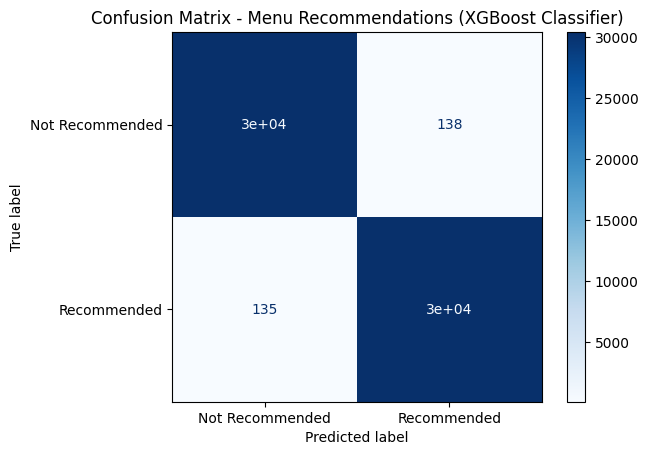

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = ConfusionMatrixDisplay.from_estimator(
    menu_xgb_class,  # Replace with individual foods model for individual results
    X_menu_test_scaled, 
    y_menu_class_test_encoded,
    display_labels=['Not Recommended', 'Recommended'],
    cmap=plt.cm.Blues,
    xticks_rotation='horizontal'
)
plt.title("Confusion Matrix - Menu Recommendations (XGBoost Classifier)")
plt.show()



ROC Curve:


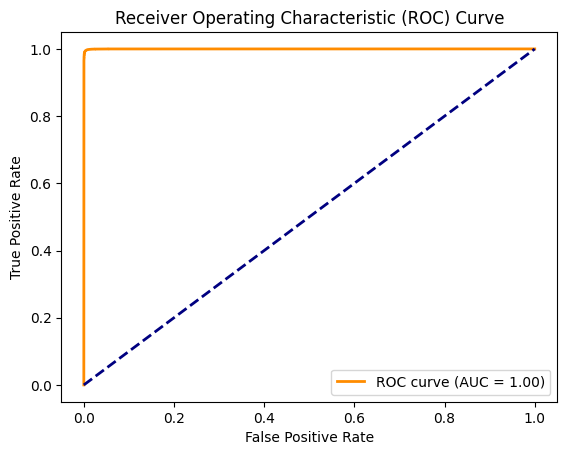

In [65]:

# ROC Curve
print("ROC Curve:")
y_menu_prob = menu_xgb_class.predict_proba(X_menu_test_scaled)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(y_menu_class_test_encoded, y_menu_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



Feature Importance:


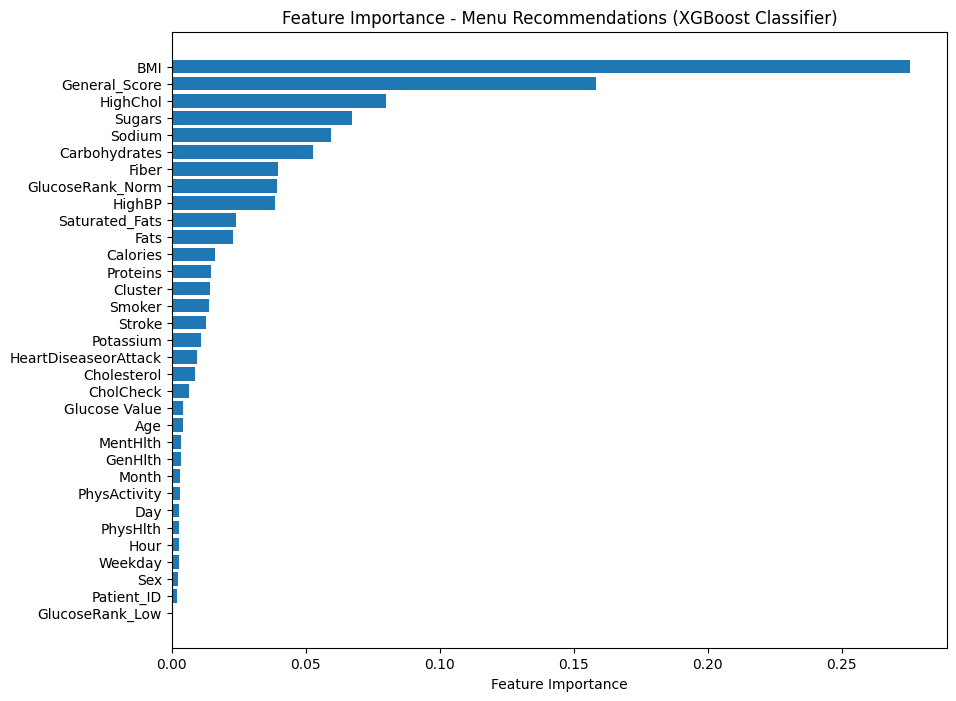

In [66]:
# Feature Importance
print("Feature Importance:")
feature_importance = menu_xgb_class.feature_importances_
features = X_menu_train.columns  
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 8))
plt.barh(features[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Menu Recommendations (XGBoost Classifier)')
plt.show()

In [ ]:
# Cross-validation for XGBoost Classifier
cv_scores = cross_val_score(
    menu_xgb_class, 
    X_menu_train_scaled, 
    y_menu_class_train_encoded, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'  # Evaluate accuracy
)

# Create a DataFrame for the results
cv_results_df = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_scores))],
    "Accuracy": cv_scores
})

# Add Mean and Standard Deviation as rows
cv_results_df.loc[len(cv_results_df)] = ["Mean", cv_scores.mean()]
cv_results_df.loc[len(cv_results_df)] = ["Std Dev", cv_scores.std()]

# Display the DataFrame
print("Cross-Validation Results for XGBoost - Menu Recommendations:")
cv_results_df



Cross-Validation Results for XGBoost - Menu Recommendations:


,Fold,Accuracy
0,Fold 1,0.995140
1,Fold 2,0.994606
2,Fold 3,0.994442
3,Fold 4,0.995365
4,Fold 5,0.994688
5,Mean,0.994848
6,Std Dev,0.000347


##### Individual Food Recommendations 

Confusion Matrix - Individual Foods:


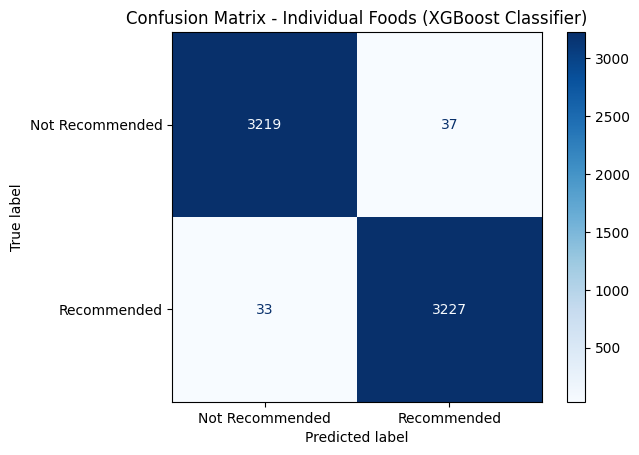

In [71]:
# Confusion Matrix for Individual Foods
print("Confusion Matrix - Individual Foods:")
conf_matrix_food = ConfusionMatrixDisplay.from_estimator(
    food_xgb_class,  # XGBoost Classifier for Individual Foods
    X_food_test_scaled, 
    y_food_class_test_encoded,
    display_labels=['Not Recommended', 'Recommended'],  # Update based on your encoded labels
    cmap=plt.cm.Blues,
    xticks_rotation='horizontal'
)
plt.title("Confusion Matrix - Individual Foods (XGBoost Classifier)")
plt.show()


ROC Curve - Individual Foods:


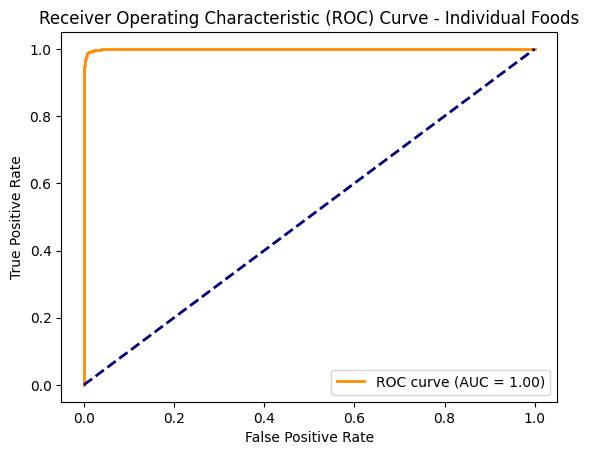

In [72]:
# ROC Curve for Individual Foods
print("ROC Curve - Individual Foods:")
y_food_prob = food_xgb_class.predict_proba(X_food_test_scaled)[:, 1]  # Probability of the positive class
fpr_food, tpr_food, thresholds_food = roc_curve(y_food_class_test_encoded, y_food_prob)
roc_auc_food = auc(fpr_food, tpr_food)

plt.figure()
plt.plot(fpr_food, tpr_food, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_food:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Individual Foods')
plt.legend(loc='lower right')
plt.show()


Feature Importance - Individual Foods:


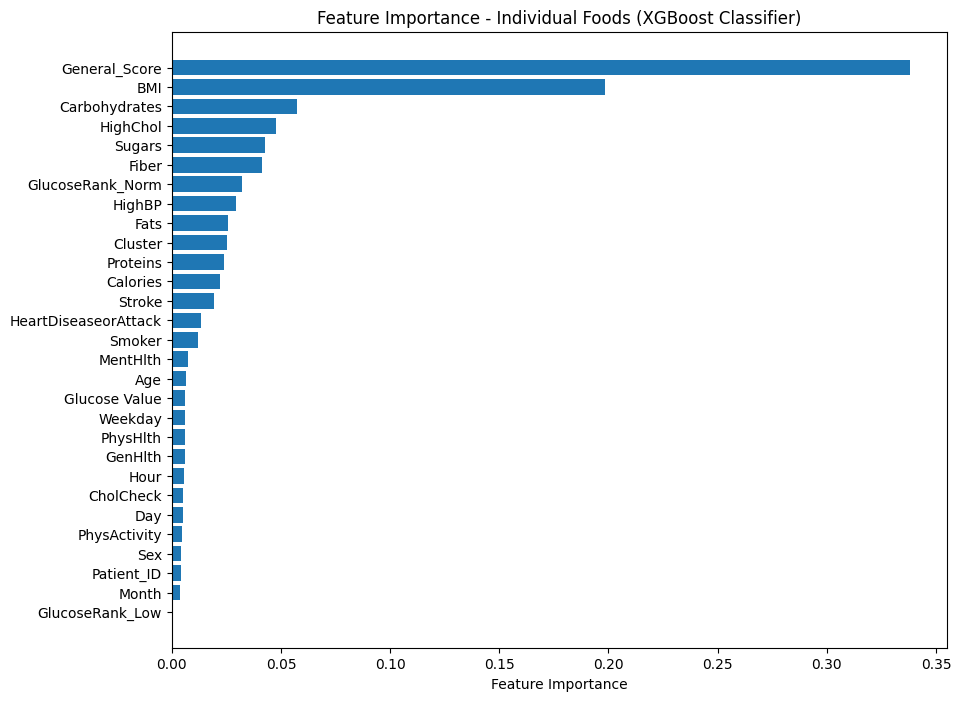

In [73]:
# Feature Importance for Individual Foods
print("Feature Importance - Individual Foods:")
feature_importance_food = food_xgb_class.feature_importances_
features_food = X_food_train.columns  # Use the feature names from the training dataset
sorted_idx_food = feature_importance_food.argsort()

plt.figure(figsize=(10, 8))
plt.barh(features_food[sorted_idx_food], feature_importance_food[sorted_idx_food])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Individual Foods (XGBoost Classifier)')
plt.show()


In [76]:
# Cross-validation for XGBoost Classifier - Individual Foods
cv_scores_food = cross_val_score(
    food_xgb_class, 
    X_food_train_scaled, 
    y_food_class_train_encoded, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)

# Create a DataFrame for the results
cv_results_food_df = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_scores_food))],  # Use cv_scores_food here
    "Accuracy": cv_scores_food  # Use cv_scores_food here
})

# Add Mean and Standard Deviation as rows
cv_results_food_df.loc[len(cv_results_food_df)] = ["Mean", cv_scores_food.mean()]
cv_results_food_df.loc[len(cv_results_food_df)] = ["Std Dev", cv_scores_food.std()]

# Display the DataFrame
print("Cross-Validation Results for XGBoost - Individual Foods:")
cv_results_food_df


Cross-Validation Results for XGBoost - Individual Foods:


,Fold,Accuracy
0,Fold 1,0.985613
1,Fold 2,0.986569
2,Fold 3,0.986953
3,Fold 4,0.989639
4,Fold 5,0.985802
5,Mean,0.986915
6,Std Dev,0.001448
